c:\Users\uqkmuroi\gitcode\ML_for_rational_design\venv\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
c:\Users\uqkmuroi\gitcode\ML_for_rational_design\venv\Lib\site-packages\botorch\acquisition\monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\ML_for_rational_design\venv\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_m

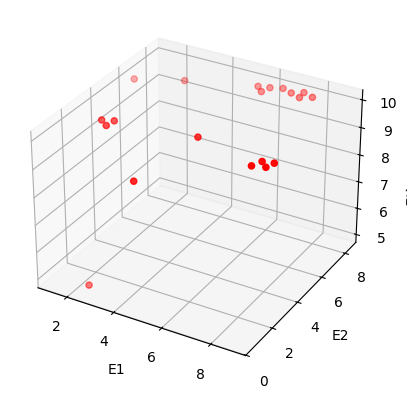

In [ ]:
# Gaussian Process Bayesian Optimization for Enzyme Tuning

import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# Constants
Km1 = 0.5
Km2 = 0.3
glc0 = 10.0
T_final = 10.0

def simulate_yield(E1, E2):
    def odes(t, y):
        glucose, pyruvate, ethanol = y
        v1 = (E1 * glucose) / (Km1 + glucose)
        v2 = (E2 * pyruvate) / (Km2 + pyruvate)
        return [-v1, v1 - v2, v2]

    sol = solve_ivp(odes, [0, T_final], [glc0, 0, 0], t_eval=[T_final])
    return sol.y[2, -1]  # Ethanol at final time

# Generate initial training data
bounds = torch.tensor([[0.1, 0.1], [10.0, 10.0]])  # E1 and E2
n_init = 10
lhs = torch.rand(n_init, 2)
train_X = (bounds[0] + (bounds[1] - bounds[0]) * lhs).double()
train_Y = torch.tensor([[simulate_yield(e1.item(), e2.item())] for e1, e2 in train_X], dtype=torch.double)

# Run BO loop
for iteration in range(10):
    model = SingleTaskGP(train_X, train_Y)#, outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    #fit_gpytorch_mll(mll)
    model.eval()
    EI = qExpectedImprovement(model=model, best_f=train_Y.max(), sampler=None)
    new_X, _ = optimize_acqf(EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20)
    new_y = torch.tensor([[simulate_yield(new_X[0,0].item(), new_X[0,1].item())]], dtype=torch.double)

    train_X = torch.cat([train_X, new_X])
    train_Y = torch.cat([train_Y, new_y])

    model.set_train_data(train_X, train_Y, strict=False)
    fit_gpytorch_mll(mll)

# Plot results
X_np = train_X.numpy()
Y_np = train_Y.numpy()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_np[:,0], X_np[:,1], Y_np[:,0], c='r', marker='o')
ax.set_xlabel("E1")
ax.set_ylabel("E2")
ax.set_zlabel("Ethanol Yield")
plt.show()